# Conformalized Quantile Regression

In [1]:
import sys
sys.path.append("..")

from astropy.io import fits
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from lib.get_config import get_config
cfg = get_config('../config/config.yaml')

Load config file >> ../config/config.yaml


In [2]:
logdir_expf = lambda exp_dir: Path(cfg['data_dir'], 'logs', exp_dir)
y_rescaled = lambda y_label: yscaler.inverse_transform(np.asarray(y_label)[...,np.newaxis]).flatten()
df = pd.read_csv(Path(cfg['data_dir'], 'catalogue', 'sdssdr16q_prop.csv'), sep=',', header=0)

## Conformal Prediction Functions
From: https://github.com/aangelopoulos/conformal-prediction

In [3]:
def optimize_params_GBR(X_train, X_val, y_train, y_val, alpha=0.1, filename='GBR_optim.pkl'):
    """Optimize Gradient Boosting for regression: https://github.com/aangelopoulos/conformal-prediction/blob/main/generation-scripts/generate-meps.py"""
    
    print("OPTIMIZE GBR ...")
    t1 = time.time()
    try:
        optim_df = pd.read_pickle(filename)
        print(f"\tLoaded GBR file")
    except:
        lrs = [0.01,]
        n_ests = [100,]
        subsamples = [1,]
        max_depths = [25,]
        # optim_df = pd.DataFrame(columns = ['lr', 'n_estimators', 'subsample', 'max_depth', 'cvg'])
        optim_list = []
        for lr, n_estimators, subsample, max_depth in itertools.product(lrs, n_ests, subsamples, max_depths):
            mean = GradientBoostingRegressor(random_state=0, learning_rate=lr, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth, loss='squared_error')
            upper = GradientBoostingRegressor(random_state=0, learning_rate=lr, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth, alpha=1-alpha/2, loss='quantile')
            lower = GradientBoostingRegressor(random_state=0, learning_rate=lr, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth, alpha=alpha/2, loss='quantile')
            mean.fit(X_train, y_train)
            upper.fit(X_train, y_train)
            lower.fit(X_train, y_train)
            pred_mean = mean.predict(X_train) 
            pred_upper = upper.predict(X_train)
            pred_lower = lower.predict(X_train)
            pred_upper = np.maximum(pred_upper, pred_lower + 1e-6)
            mse = ( (y_train - pred_mean)**2 ).mean()
            cvg = ( (y_train <= pred_upper) & (y_train >= pred_lower) ).mean()
            # optim_dict = { 'lr' : lr, 'n_estimators' : n_estimators, 'subsample' : subsample, 'max_depth' : max_depth, 'mse' : mse, 'cvg' : cvg }
            # optim_df = optim_df.concat(optim_dict, ignore_index=True)
            optim_list.append([lr, n_estimators, subsample, max_depth, mse, cvg])
        optim_df = pd.DataFrame(optim_list, columns=['lr', 'n_estimators', 'subsample', 'max_depth', 'mse', 'cvg'])
        optim_df.to_pickle(filename)
    idx_quantiles = np.argmin(np.abs(optim_df['cvg'] - (1 - alpha)))
    idx_mean = np.argmin(optim_df['mse'])
    optim_df_quantiles = optim_df.loc[idx_quantiles]
    optim_df_mean = optim_df.loc[idx_mean]
    # GBR
    mean = GradientBoostingRegressor(random_state=0, learning_rate=optim_df_mean['lr'], n_estimators=int(optim_df_mean['n_estimators']), subsample=optim_df_mean['subsample'], max_depth=int(optim_df_mean['max_depth']), loss='squared_error')
    upper = GradientBoostingRegressor(random_state=0, learning_rate=optim_df_quantiles['lr'], n_estimators=int(optim_df_quantiles['n_estimators']), subsample=optim_df_quantiles['subsample'], max_depth=int(optim_df_quantiles['max_depth']), alpha=1-alpha/2, loss='quantile')
    lower = GradientBoostingRegressor(random_state=0, learning_rate=optim_df_quantiles['lr'], n_estimators=int(optim_df_quantiles['n_estimators']), subsample=optim_df_quantiles['subsample'], max_depth=int(optim_df_quantiles['max_depth']), alpha=alpha/2, loss='quantile')
    mean.fit(X_train, y_train)
    upper.fit(X_train, y_train)
    lower.fit(X_train, y_train)
    pred_mean_train = mean.predict(X_train)
    pred_mean_val = mean.predict(X_val)
    pred_upper_val = upper.predict(X_val)
    pred_lower_val = lower.predict(X_val)
    print(f"GBR done in >> {time.time() - t1:.3g} s")
    return pred_mean_val, pred_upper_val, pred_lower_val


def cqr(X, target, mean, upper, lower, n=1000, alpha=0.1):
    """
    Conformalized quantile regression from medical expenditure regression notebook: https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/meps-cqr.ipynb
    n: Number of calibration points
    alpha: 1-alpha is the desired coverage
    """
    
    # Split the softmax scores into calibration and validation sets (save the shuffling)
    idx = np.array([1]*n + [0]*(target.shape[0] - n)) > 0
    np.random.shuffle(idx)
    cal_target, val_target = target[idx], target[~idx]
    cal_mean, val_mean = mean[idx], mean[~idx]
    cal_upper, val_upper = upper[idx], upper[~idx]
    cal_lower, val_lower = lower[idx], lower[~idx]
    cal_X, val_X = X[idx], X[~idx]
    
    # Conformal prediction happens here
    # Get scores. cal_upper.shape[0] == cal_lower.shape[0] == n
    cal_scores = np.maximum(cal_target - cal_upper, cal_lower - cal_target)
    # Get the score quantile
    qhat = np.quantile(cal_scores, np.ceil((n + 1)*(1 - alpha))/n, method='higher')
    # Deploy (output=lower and upper adjusted quantiles)
    prediction_sets = [val_lower - qhat, val_upper + qhat]
    
    # Calculate empirical coverage (before and after calibration)
    prediction_sets_uncalibrated = [val_lower, val_upper]
    empirical_coverage_uncalibrated = ((val_target >= prediction_sets_uncalibrated[0]) & (val_target <= prediction_sets_uncalibrated[1])).mean()
    print(f"The empirical coverage before calibration is: {empirical_coverage_uncalibrated}")
    empirical_coverage = ((val_target >= prediction_sets[0]) & (val_target <= prediction_sets[1])).mean()
    print(f"The empirical coverage after calibration is: {empirical_coverage}")
    
    return {
        'cal': {'X': cal_X, 'target': cal_target, 'mean': cal_mean, 'upper': cal_upper, 'lower': cal_lower},
        'val': {'X': val_X, 'target': val_target, 'mean': val_mean, 'upper': val_upper, 'lower': val_lower},
        'qhat': qhat
    }


## Plot Functions

In [4]:
def fit_pca(data, n_components=1):
    """Dimensionality reduction with PCA"""
    pc = PCA(n_components=n_components).fit_transform(data)
    return pc.flatten() if n_components==1 else pc


def plot_predictioninterval(X, target, mean, lower, upper, qhat):
    """Plot prediction interval before and after calibration"""
    X_sorted_idx = np.argsort(X)
    X_sorted = X[X_sorted_idx]
    mean_sorted, lower_sorted, upper_sorted = mean.iloc[X_sorted_idx], lower.iloc[X_sorted_idx], upper.iloc[X_sorted_idx]
    color = plt.get_cmap('tab10')
    fig, ax = plt.subplots()
    ax.scatter(X, target, color=color(0), s=10, label='target')
    ax.plot(X_sorted, mean_sorted, color=color(1), lw=1, label='mean')
    ci_fill = ax.fill_between(X_sorted, lower_sorted-qhat, upper_sorted+qhat, color=color(1), alpha=0.2, label='after calibration')
    ax.fill_between(X_sorted, lower_sorted, upper_sorted, color=color(2), alpha=0.2, label='before calibration')
    ax.legend()
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    plt.show()


def plot_predvstarget(target, pred, onetoone_refloc=0, X=None):
    """Plot prediction against target"""
    
    iline_kwargs = {'ls': '--', 'color': 'gray', 'alpha': 0.6}
    fig, ax = plt.subplots()
    ax.scatter(target, pred, s=5)
    ax.set_xlabel('Target')
    ax.set_ylabel('Prediction')
    ax.axline([onetoone_refloc, onetoone_refloc], slope=1, **iline_kwargs)
    plt.show()
    
    if X is not None:
        fig, ax = plt.subplots()
        ax.scatter(X, pred-target, s=5)
        ax.set_xlabel(r'$x$')
        ax.set_ylabel('Prediction - Target')
        ax.axhline(y=0, **iline_kwargs)
        plt.show()


## Experiment 3a

- Input flux: flux_line
- NN model: Dense with list_linear=[256, 64, 8]
- Loss: MSE

In [5]:
logdir_exp = logdir_expf('20230221/154806_LOGMBH_HB')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

## Run GradientBoostingRegressor

In [6]:
# --------------- #
# Run GradientBoostingRegressor
# --------------- #
# y as label
mean_test, upper_test, lower_test = optimize_params_GBR(dffeatures_train[feature_keys].to_numpy(), dffeatures_test[feature_keys].to_numpy(), dffeatures_train['label'].to_numpy(), dffeatures_test['label'].to_numpy(), filename=Path(logdir_exp, 'GBR_optim.pkl'))
df_gbr = pd.DataFrame({'objid': dffeatures_test['objid'], 'label': dffeatures_test['label'], 'mean': mean_test, 'upper': upper_test, 'lower': lower_test})
df_gbr.to_csv(Path(logdir_exp, 'gbr.csv'), index=False, float_format='%g')

# y as scaled_label
mean_test, upper_test, lower_test = optimize_params_GBR(dffeatures_train[feature_keys].to_numpy(), dffeatures_test[feature_keys].to_numpy(), dffeatures_train['scaled_label'].to_numpy(), dffeatures_test['scaled_label'].to_numpy(), filename=Path(logdir_exp, 'GBR_optim_yscaled.pkl'))
# Rescale predicted y
mean_test = y_rescaled(mean_test)
upper_test = y_rescaled(upper_test)
lower_test = y_rescaled(lower_test)
df_gbryscaled = pd.DataFrame({'objid': dffeatures_test['objid'], 'label': dffeatures_test['label'], 'mean': mean_test, 'upper': upper_test, 'lower': lower_test})
df_gbryscaled.to_csv(Path(logdir_exp, 'gbr_yscaled.csv'), index=False, float_format='%g')

OPTIMIZE GBR ...
GBR done in >> 18.9 s
OPTIMIZE GBR ...
GBR done in >> 19.1 s


## GBR Results

### Without y rescaling

In [7]:
df_gbr = pd.read_csv(Path(logdir_exp, 'gbr.csv'), header=0)
cqr_dict = cqr(dffeatures_test[feature_keys], df_gbr['label'], df_gbr['mean'], df_gbr['upper'], df_gbr['lower'], n=500, alpha=0.1)

The empirical coverage before calibration is: 0.8364875094625284
The empirical coverage after calibration is: 0.8955336866010598


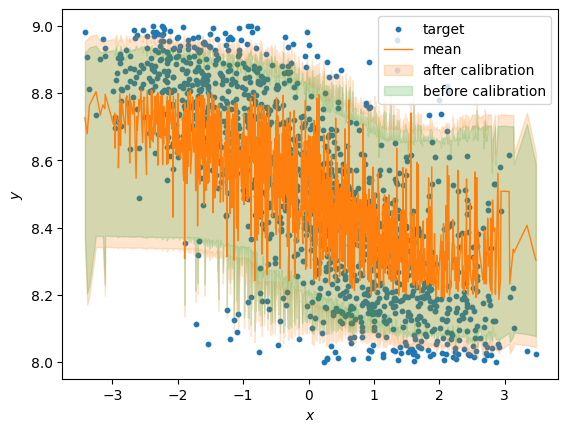

In [8]:
val_X_pca = fit_pca(cqr_dict['val']['X'], n_components=1)
plot_predictioninterval(val_X_pca, cqr_dict['val']['target'], cqr_dict['val']['mean'], cqr_dict['val']['lower'], cqr_dict['val']['upper'], cqr_dict['qhat'])

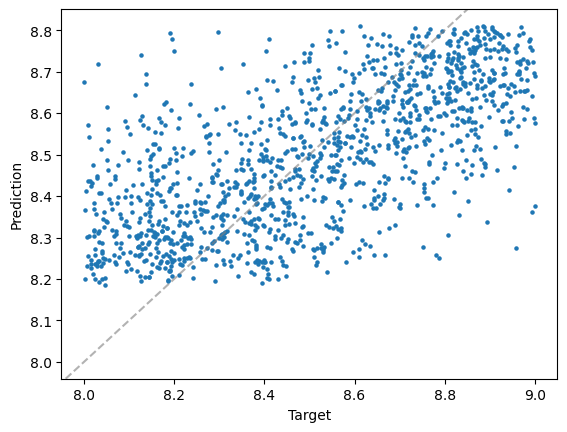

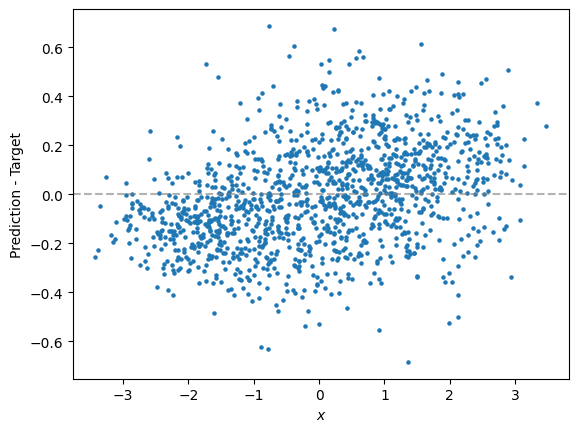

In [9]:
plot_predvstarget(cqr_dict['val']['target'], cqr_dict['val']['mean'], onetoone_refloc=8, X=val_X_pca)

### With y rescaling

In [10]:
df_gbryscaled = pd.read_csv(Path(logdir_exp, 'gbr_yscaled.csv'), header=0)
cqr_dict = cqr(dffeatures_test[feature_keys], df_gbryscaled['label'], df_gbryscaled['mean'], df_gbryscaled['upper'], df_gbryscaled['lower'], n=500, alpha=0.1)

The empirical coverage before calibration is: 0.8319454958364875
The empirical coverage after calibration is: 0.915215745647237


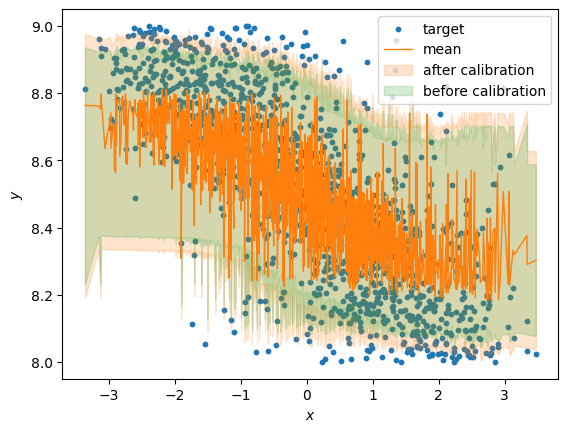

In [11]:
val_X_pca = fit_pca(cqr_dict['val']['X'], n_components=1)
plot_predictioninterval(val_X_pca, cqr_dict['val']['target'], cqr_dict['val']['mean'], cqr_dict['val']['lower'], cqr_dict['val']['upper'], cqr_dict['qhat'])

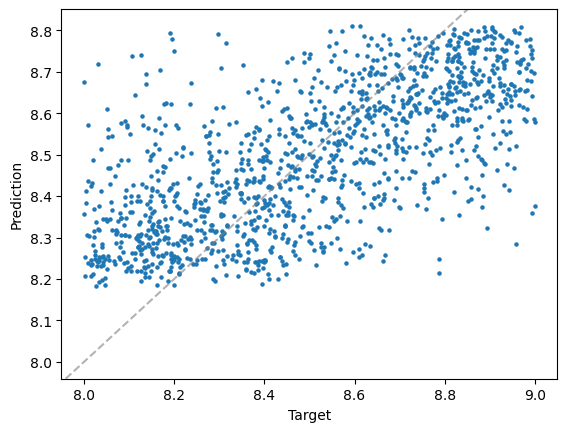

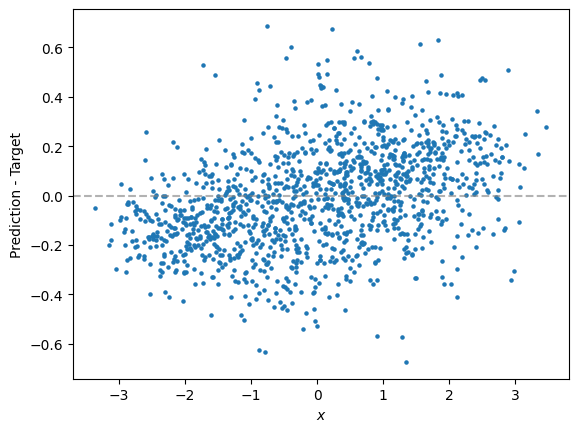

In [12]:
plot_predvstarget(cqr_dict['val']['target'], cqr_dict['val']['mean'], onetoone_refloc=8, X=val_X_pca)

### Experiment 3d

- Input flux: flux_line of MgII
- NN model: Dense with list_linear=[256, 64, 8]
- Loss: MSE

In [13]:
logdir_exp = logdir_expf('20230221/160717_LOGMBH_MGII')

datasplit_idx = pd.read_pickle(Path(logdir_exp, 'datasplitidx.pkl'))
df_features = pd.read_pickle(Path(logdir_exp, 'features.pkl'))
yscaler = pd.read_pickle(Path(logdir_exp, 'yscaler.pkl'))

feature_keys = [k for k in df_features.columns if isinstance(k, int)]
dffeatures_train = df_features.loc[datasplit_idx['train']]
dffeatures_test = df_features.loc[datasplit_idx['test']]

## Run GradientBoostingRegressor

In [14]:
# --------------- #
# Run GradientBoostingRegressor
# --------------- #
# y as label
mean_test, upper_test, lower_test = optimize_params_GBR(dffeatures_train[feature_keys].to_numpy(), dffeatures_test[feature_keys].to_numpy(), dffeatures_train['label'].to_numpy(), dffeatures_test['label'].to_numpy(), filename=Path(logdir_exp, 'GBR_optim.pkl'))
df_gbr = pd.DataFrame({'objid': dffeatures_test['objid'], 'label': dffeatures_test['label'], 'mean': mean_test, 'upper': upper_test, 'lower': lower_test})
df_gbr.to_csv(Path(logdir_exp, 'gbr.csv'), index=False, float_format='%g')

# y as scaled_label
mean_test, upper_test, lower_test = optimize_params_GBR(dffeatures_train[feature_keys].to_numpy(), dffeatures_test[feature_keys].to_numpy(), dffeatures_train['scaled_label'].to_numpy(), dffeatures_test['scaled_label'].to_numpy(), filename=Path(logdir_exp, 'GBR_optim_yscaled.pkl'))
# Rescale predicted y
mean_test = y_rescaled(mean_test)
upper_test = y_rescaled(upper_test)
lower_test = y_rescaled(lower_test)
df_gbryscaled = pd.DataFrame({'objid': dffeatures_test['objid'], 'label': dffeatures_test['label'], 'mean': mean_test, 'upper': upper_test, 'lower': lower_test})
df_gbryscaled.to_csv(Path(logdir_exp, 'gbr_yscaled.csv'), index=False, float_format='%g')

OPTIMIZE GBR ...
GBR done in >> 20 s
OPTIMIZE GBR ...
GBR done in >> 20 s


## GBR Results

### Without y rescaling

In [15]:
df_gbr = pd.read_csv(Path(logdir_exp, 'gbr.csv'), header=0)
cqr_dict = cqr(dffeatures_test[feature_keys], df_gbr['label'], df_gbr['mean'], df_gbr['upper'], df_gbr['lower'], n=500, alpha=0.1)

The empirical coverage before calibration is: 0.8304314912944739
The empirical coverage after calibration is: 0.8690386071158214


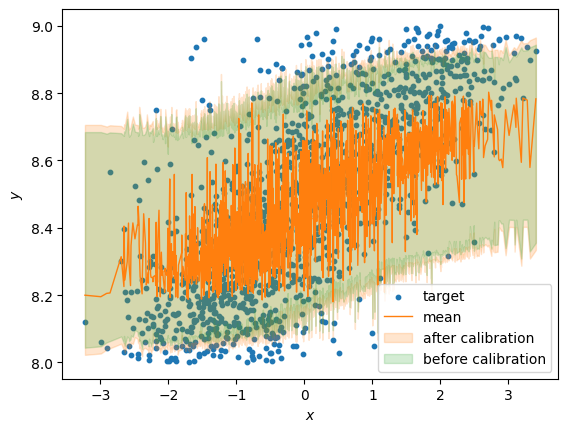

In [16]:
val_X_pca = fit_pca(cqr_dict['val']['X'], n_components=1)
plot_predictioninterval(val_X_pca, cqr_dict['val']['target'], cqr_dict['val']['mean'], cqr_dict['val']['lower'], cqr_dict['val']['upper'], cqr_dict['qhat'])

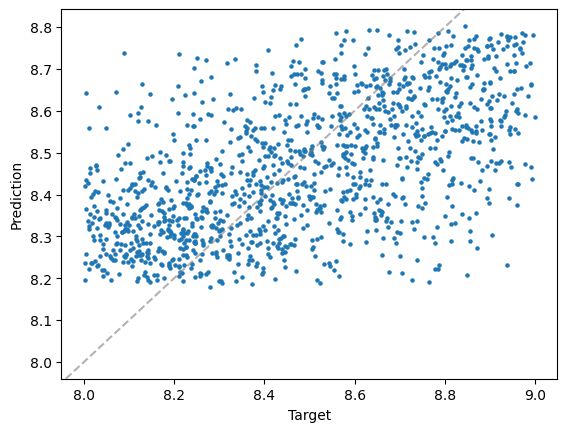

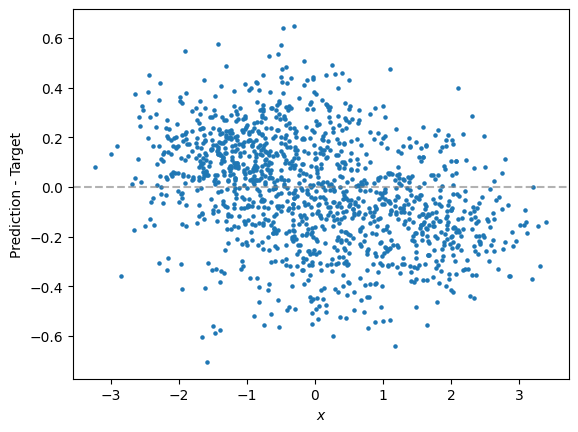

In [17]:
plot_predvstarget(cqr_dict['val']['target'], cqr_dict['val']['mean'], onetoone_refloc=8, X=val_X_pca)

### With y rescaling

In [18]:
df_gbryscaled = pd.read_csv(Path(logdir_exp, 'gbr_yscaled.csv'), header=0)
cqr_dict = cqr(dffeatures_test[feature_keys], df_gbryscaled['label'], df_gbryscaled['mean'], df_gbryscaled['upper'], df_gbryscaled['lower'], n=500, alpha=0.1)

The empirical coverage before calibration is: 0.8425435276305829
The empirical coverage after calibration is: 0.9000757002271007


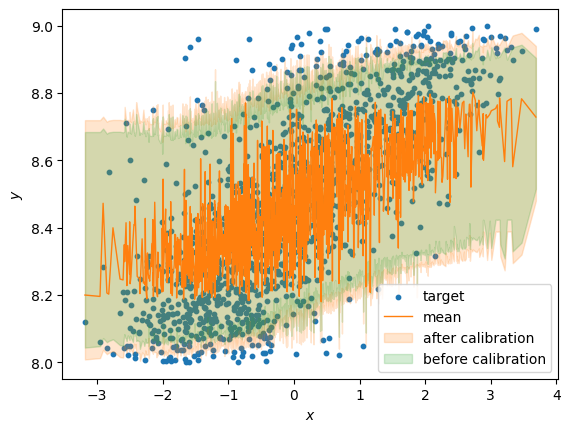

In [19]:
val_X_pca = fit_pca(cqr_dict['val']['X'], n_components=1)
plot_predictioninterval(val_X_pca, cqr_dict['val']['target'], cqr_dict['val']['mean'], cqr_dict['val']['lower'], cqr_dict['val']['upper'], cqr_dict['qhat'])

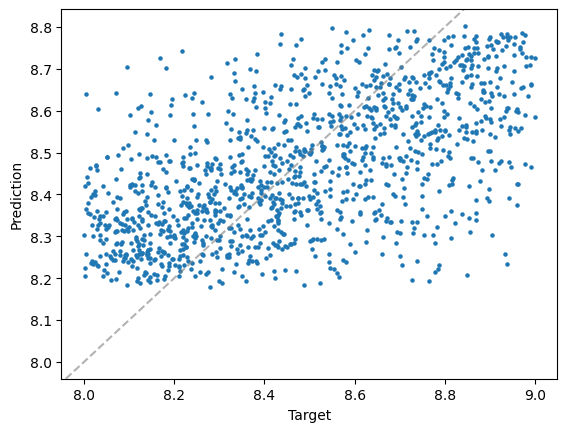

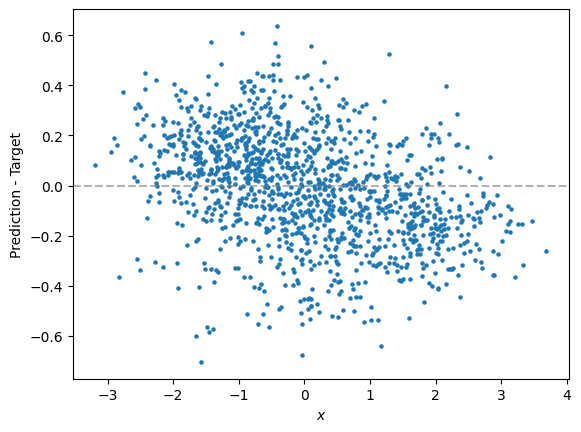

In [20]:
plot_predvstarget(cqr_dict['val']['target'], cqr_dict['val']['mean'], onetoone_refloc=8, X=val_X_pca)